# Dynamics

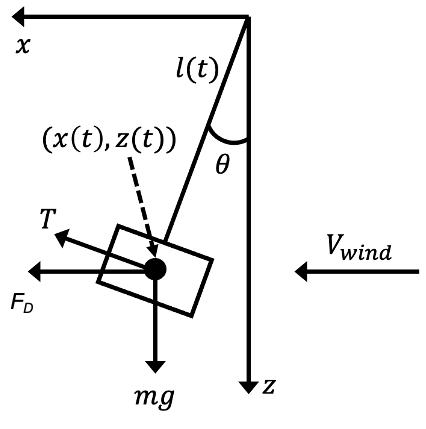

### Position and $x$ velocity of the droid
LooKing at the FBD above:
$$
\begin{aligned}
& x(t)=l(t) \sin \theta(t) \\
& \dot{x}(t)=\dot{l} \sin \theta+l \dot{\theta} \cos \theta \\
& z(t)=l \cos \theta
\end{aligned}
$$

### Wind Drag
The drag is proportional to the square of the relative speed between the wind and the droid (assumed to be dominant in $x$ direction). The direction of drag depends on the sign of $V_{\text{rel}}$
$$
\begin{aligned}
& V_{\text {rel }}=V_{\text {wind}}-\dot{x}=V_{\text {wind}}-(\dot{l} \sin \theta+l \dot{\theta} \cos \theta) \\
& F_D=\underbrace{\frac{1}{2} \rho C_d A}_k V_{\text {rel }}\left|V_{\text {rel }}\right|
\end{aligned}
$$

### Euler-Lagrange Equation of Motion
Using Euler-Lagrange formula is easier than trying to derive the coriolis effect manually.

#### Kinetic energy $T$
$$
\begin{aligned}
T & =\frac{1}{2} m v^2 \\
& =\frac{1}{2} m\left(V_{tangential}^2+V_{radial}^2\right) \\
& =\frac{1}{2} m\left[(l \dot{\theta})^2+(\dot{l})^2\right]
\end{aligned}
$$

#### Potential energy $U$
Positive $z$ and $g$ act in same direction, so potential energy is negative as defined in FBD.
$$
\begin{aligned}
U & =-m g z \\
& =-m g l \cos \theta
\end{aligned}
$$

#### Lagrangian $\mathcal{L}$
$$
\begin{aligned}
\mathcal{L} & =T-U \\
& =\frac{1}{2} m\left[(l \dot{\theta})^2+(\dot{l})^2\right]+m g l \cos \theta
\end{aligned}
$$

#### Euler-Lagrange:
$$
\begin{aligned}
& \frac{d}{d t}\left(\frac{\partial \mathcal{L}}{\partial \dot{\theta}}\right)-\frac{\partial L}{\partial \theta}=Q_\theta \\
& \frac{d}{d t}\left(m l^2 \dot{\theta}\right)+m g l \sin \theta=Q_\theta \\
& \underbrace{2 m l \dot{l} \dot{\theta}}_{coriolis} 
+ \underbrace{m l^2 \ddot{\theta}}_{\substack{\text { angular } \\
\text { momentum }}} + m g l \sin \theta=T l+k l V_{\text {rel }}\left|V_{\text {rel }}\right| \cos \theta \\
\end{aligned}
$$

$$
\boxed{\ddot{\theta}=\frac{T}{m l}+\frac{k}{m l} V_{\text {rel }}\left|V_{\text {rel }}\right| \cos \theta-\frac{g}{l} \sin \theta-2 \frac{\dot{l}}{l} \dot{\theta}} \quad \dots \text{varying tether}
$$

For the special case where the tether length is kept constant (no reel-out), $\dot{l}=0$:

$$
\boxed{\ddot{\theta}=\frac{T}{m l}+\frac{k}{m l} V_{\text {rel }}\left|V_{\text {rel }}\right| \cos \theta-\frac{g}{l} \sin \theta} \quad \dots \text{constant tether}
$$

### Linearization Strategy

We want to convert the nonlinear equation $\ddot{\theta}=f(\theta, \dot{\theta}, l, T)$ into a linear system:
$$
\delta \dot{\mathbf{x}}=A \delta \mathbf{x}+B \delta \mathbf{u}
$$

We use a Taylor Series Expansion about the current operating point ($\mathbf{x}_{\text {op}}, \mathbf{u}_{\text {op}}$). This involves computing the partial derivatives (Jacobians) of the dynamics with respect to the state and input.
1. State Vector: $\mathbf{x}=[\theta, \dot{\theta}, l]^T$
2. Input: $u=[T]$

$$
\dot{\mathbf{x}} =
\left[\begin{array}{l}
\dot{\theta} \\
\ddot{\theta}
\end{array}\right]=\left[\begin{array}{c}
\dot{\theta} \\
\frac{T}{m l}+\frac{k}{m l} V_{\text {rel }}\left|V_{\text {rel }}\right| \cos \theta-\frac{g}{l} \sin \theta-2 \frac{\dot{l}}{l} \dot{\theta}
\end{array}\right]
$$

3. First-order Taylor Expansion:
$$
\dot{\mathbf{x}} \approx \mathbf{f}\left(\mathbf{x}_{o p}, u_{o p}\right)+\underbrace{\left.\frac{\partial \mathbf{f}}{\partial \mathbf{x}}\right|_{o p}}_A\left(\mathbf{x}-\mathbf{x}_{o p}\right)+\underbrace{\left.\frac{\partial \mathbf{f}}{\partial u}\right|_{o p}}_B\left(u-u_{o p}\right)+\ldots
$$
$$\dot{\mathbf{x}} \approx \mathbf{f}(\mathbf{x}_{op}, \mathbf{u}_{op}) + A (\mathbf{x} - \mathbf{x}_{op}) + B (\mathbf{u} - \mathbf{u}_{op})$$

To find the $A$ and $B$ matrices, to avoid using the chain and product rules by hand for the nested dependencies on the state in the drag term's $V_{\text{rel}}$

We can further write the equation in affine form:
$$\dot{\mathbf{x}} \approx A \mathbf{x} + B \mathbf{u} + \underbrace{(\mathbf{f}(\mathbf{x}_{op}, \mathbf{u}_{op}) - A \mathbf{x}_{op} - B \mathbf{u}_{op})}_{\mathbf{d} \text{ (Drift Term)}}$$



In [78]:
import sympy as sp
import jax.numpy as jnp
from jax import jit 
import numpy as np
import matplotlib.pyplot as plt

def get_symbolic_jacobian_matrices():
    # 1. Define Symbols
    # theta, theta_dot, l are STATES
    theta, theta_dot, l = sp.symbols(r'theta theta_dot l', real=True)
    
    # T is the only CONTROL now. 
    # l_dot is a PARAMETER (fixed reel rate)
    T, l_dot = sp.symbols(r'T l_dot', real=True)
    
    m, g, k, V_wind = sp.symbols(r'm g k V_wind', real=True)

    # 2. Physics Model
    # Note: l_dot here is treated as a known constant value passed in arguments
    x_dot_val = l_dot * sp.sin(theta) + l * theta_dot * sp.cos(theta)
    V_rel = V_wind - x_dot_val
    F_drag_x = k * V_rel * sp.Abs(V_rel) 
    
    # Dynamics (f1, f2, f3)
    f1 = theta_dot
    
    # The dynamics still include l_dot terms (Coriolis), but they are now "drift" terms, not control terms
    f2 = (T/(m*l)) - (g/l)*sp.sin(theta) - (2*l_dot/l)*theta_dot + (F_drag_x*sp.cos(theta))/(m*l)
    
    # The 3rd state (l) evolves at the fixed reel rate
    f3 = l_dot 
    
    # 3. Vectors
    state = sp.Matrix([theta, theta_dot, l])
    
    # --- CHANGE: Control vector is now just Thrust ---
    u_vec = sp.Matrix([T]) 
    
    f_vec = sp.Matrix([f1, f2, f3])
    
    # 4. Jacobians
    A_sym = f_vec.jacobian(state)
    
    # B_sym will now be (3, 1) because u_vec is size 1
    B_sym = f_vec.jacobian(u_vec)
    
    # Drift calculation for linearization checks (optional)
    d_sym = f_vec - A_sym @ state - B_sym @ u_vec

    # Arguments list must still include l_dot so we can pass the fixed rate (e.g., 1.5) at runtime
    args = (theta, theta_dot, l, T, l_dot, m, g, k, V_wind)

    # 5. Open Loop & Disturbance Setup
    # For Control Affine Form: dx = f_ol(x) + B(x)u + E(x)d
    
    # --- CRITICAL CHANGE ---
    # We substitute T=0 (No Thrust) and V_wind=0 (No Wind).
    # We DO NOT substitute l_dot=0. 
    # The "Open Loop" dynamics now naturally include the reeling motion and Coriolis forces.
    f_open_loop = f_vec.subs({T: 0, V_wind: 0}) 
    
    d_vec = sp.Matrix([V_wind])
    E_sym = f_vec.jacobian(d_vec) # Disturbance Jacobian

    # 6. Convert to JAX-compatible functions 
    f_jax = sp.lambdify(args, f_vec, modules='jax')
    f_open_loop_jax = sp.lambdify(args, f_open_loop, modules='jax')
    A_jax = sp.lambdify(args, A_sym, modules='jax')
    B_jax = sp.lambdify(args, B_sym, modules='jax')
    d_jax = sp.lambdify(args, d_sym, modules='jax')
    E_jax = sp.lambdify(args, E_sym, modules='jax')
    
    return f_jax, f_vec, A_jax, A_sym, B_jax, B_sym, d_jax, d_sym, f_open_loop_jax, f_open_loop, E_jax, E_sym

# Generate the functions ONCE
f_fn, f_vec, A_fn, A_sym, B_fn, B_sym, d_fn, d_sym, f_open_loop_fn, f_open_loop, E_fn, E_sym = get_symbolic_jacobian_matrices()

### Constants

In [79]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from jax.scipy.interpolate import RegularGridInterpolator
from jax import grad
import cvxpy as cp

# Simulation Parameters
dt = 0.1
T_sim = 20
N = int(T_sim/dt)
random_seed = 42

# Physics Parameters
rho = 1.225
Cd = 1.0
S = 0.1
k_aero = 0.5 * rho * Cd * S
base_params = {'m': 5.0, 'g': 9.81, 'k': k_aero}

# Initial Conditions
theta_0 = 0.0
theta_dot_0 = 0.0
l0 = 5.0
x0 = jnp.array([theta_0, theta_dot_0, l0]) 

# Controller
Kp = 20
Ki = 10
Kd = 15
eqm_theta = 0.0

# Wind Parameters
v_gust = 3.0
mean = -5.0
sigma = 2.0
tau = 5.0

# Constraints
angle_bound_deg = 1     # <--- SAFETY PARAMETER
u_max_val = 20.0        # Thrust
l_dot_max_val = 1.5     # Reel rate
ell_min, ell_max = 5.0, 100.0

In [80]:
def pid_control_law(target_theta, state, integral_error, dt, Kp, Ki, Kd, current_wind, k_aero, use_drag_scaling=True):
    theta, theta_dot, _ = state
    
    if use_drag_scaling:
        est_drag = k_aero * (current_wind**2)
        drag_scale = 1.0 + est_drag
    else:
        drag_scale = 1.0
    
    error = target_theta - theta
    d_error = -theta_dot 
    
    p_term = (Kp * error) * drag_scale 
    i_term = Ki * integral_error
    d_term = Kd * d_error
    
    u_thrust = np.clip(p_term + i_term + d_term, -100.0, 100.0) 
    return u_thrust, integral_error + error * dt

def run_simulation(wind_profile, gains):
    x_hist = [x0]
    u_hist = []
    curr_x = x0
    integral_err = 0.0
    
    Kp, Ki, Kd = gains['Kp'], gains['Ki'], gains['Kd']
    use_scaling = gains['scale']
    
    for i in range(N):
        curr_wind = wind_profile[i]
        
        thrust, integral_err = pid_control_law(
            eqm_theta, curr_x, integral_err, dt, 
            Kp, Ki, Kd, 
            curr_wind, base_params['k'], 
            use_drag_scaling=use_scaling
        )
        
        u_current = jnp.array([thrust, l_dot_max_val]) 
        u_hist.append(thrust)
        
        curr_p_args = (base_params['m'], base_params['g'], base_params['k'], curr_wind)
        args_nl = (*curr_x, *u_current, *curr_p_args)
        
        x_dot = jnp.array(f_fn(*args_nl)).flatten()
        curr_x = curr_x + x_dot * dt
        x_hist.append(curr_x)
        
    return np.array(x_hist), np.array(u_hist)

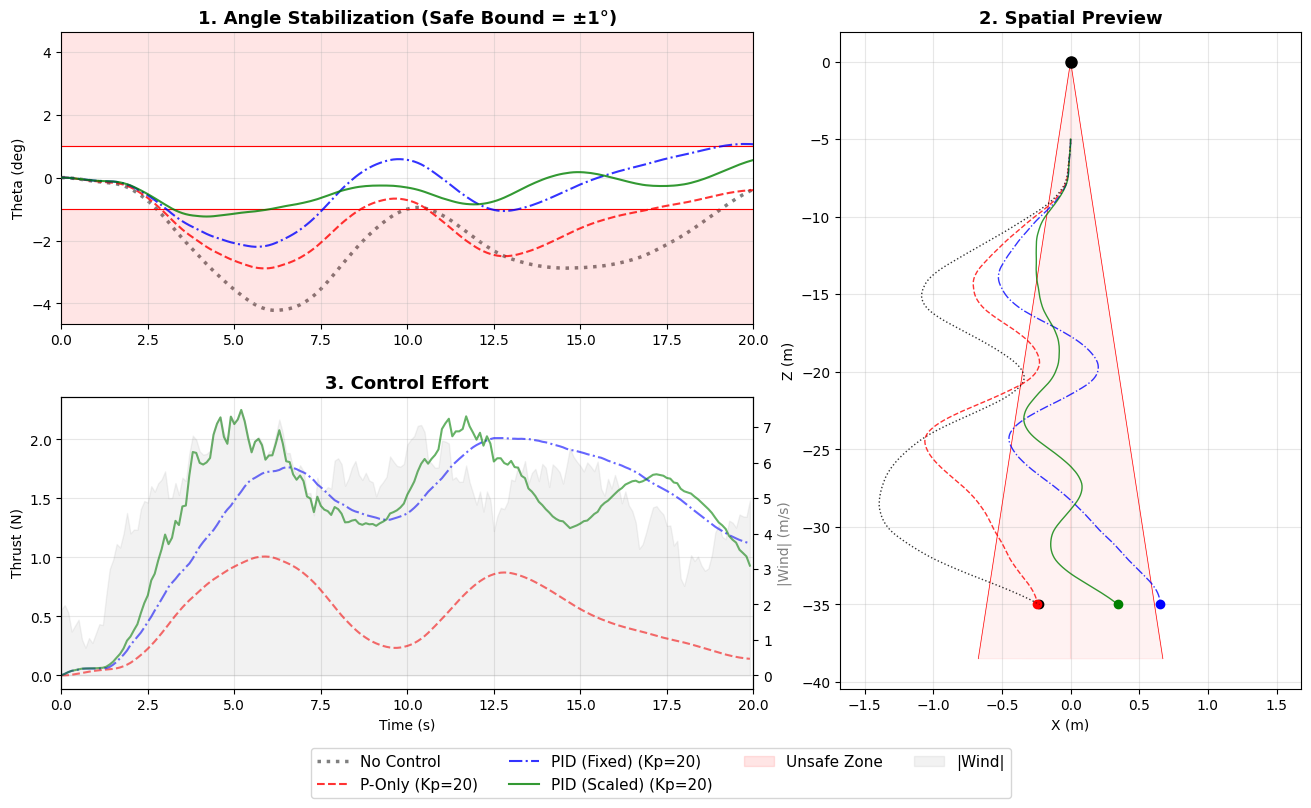

In [81]:
# --- 1. SHARED HELPER FUNCTIONS ---
def generate_wind_profile(N, dt, v_gust, mean, sigma, tau):
    noise_scale = sigma * np.sqrt(2 * dt / tau)
    wind_hist = []
    np.random.seed(42) # Fixed seed for consistency
    val = v_gust
    for _ in range(N):
        noise = np.random.normal(0, 1)
        val = val * (1 - dt / tau) + noise * noise_scale
        wind_hist.append(mean + val)
    return np.array(wind_hist)

def plot_all_results(results_dict, wind_arr, angle_bound, T_sim, dt):
    """Reusable plotting function for consistency."""
    N = len(wind_arr)
    t = np.arange(N+1) * dt
    t_u = np.arange(N) * dt
    
    fig = plt.figure(figsize=(16, 9))
    plt.subplots_adjust(bottom=0.15) 
    gs = GridSpec(2, 2, width_ratios=[1.5, 1.0], wspace=0.15, hspace=0.25)

    # -- Plot 1: Angle --
    ax1 = fig.add_subplot(gs[0, 0])
    max_angle_seen = angle_bound * 1.5
    
    for name, res in results_dict.items():
        theta_deg = np.degrees(res['x'][:, 0])
        max_angle_seen = max(max_angle_seen, np.max(np.abs(theta_deg)))
        
        # Style logic
        if "CBF" in name: lw, alpha, zorder = 2.5, 1.0, 10
        elif "No Control" in name: lw, alpha, zorder = 2.5, 0.5, 1
        else: lw, alpha, zorder = 1.5, 0.8, 5
            
        ax1.plot(t, theta_deg, color=res['color'], linestyle=res['style'], 
                 linewidth=lw, alpha=alpha, label=res['label'], zorder=zorder)

    # Safety Bounds
    ax1.axhspan(angle_bound, 180, color='red', alpha=0.1, label='Unsafe Zone')
    ax1.axhspan(-180, -angle_bound, color='red', alpha=0.1)
    ax1.axhline(angle_bound, color='r', linestyle='-', linewidth=0.8)
    ax1.axhline(-angle_bound, color='r', linestyle='-', linewidth=0.8)
    
    ax1.set_title(f"1. Angle Stabilization (Safe Bound = ±{angle_bound}°)", fontsize=13, fontweight='bold')
    ax1.set_ylabel("Theta (deg)")
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-min(180, max_angle_seen * 1.1), min(180, max_angle_seen * 1.1))
    ax1.set_xlim(0, T_sim)

    # -- Plot 2: Spatial --
    ax2 = fig.add_subplot(gs[:, 1])
    max_L = max([np.max(r['x'][:, 2]) for r in results_dict.values()]) if results_dict else 10
    cone_L = max_L * 1.1
    th_b = np.radians(angle_bound)
    
    # Draw Cone
    for sign in [-1, 1]:
        x_c = sign * cone_L * np.sin(th_b)
        z_c = -cone_L * np.cos(th_b)
        ax2.fill([0, 0, x_c], [0, -cone_L, z_c], color='red', alpha=0.05)
        ax2.plot([0, x_c], [0, z_c], 'r-', linewidth=0.5)

    for name, res in results_dict.items():
        l, theta = res['x'][:, 2], res['x'][:, 0]
        X, Z = l * np.sin(theta), -l * np.cos(theta)
        
        lw = 2.0 if "CBF" in name else 1.0
        zorder = 10 if "CBF" in name else 5
        
        ax2.plot(X, Z, color=res['color'], linestyle=res['style'], 
                 linewidth=lw, alpha=0.8, label=name, zorder=zorder)
        ax2.plot(X[-1], Z[-1], marker='o', color=res['color'], markersize=6)

    ax2.plot(0, 0, 'ko', markersize=8, label='Anchor')
    ax2.set_title("2. Spatial Preview", fontsize=13, fontweight='bold')
    ax2.set_xlabel("X (m)"); ax2.set_ylabel("Z (m)")
    ax2.set_xlim(-cone_L*np.sin(th_b)*2.5, cone_L*np.sin(th_b)*2.5)
    ax2.grid(True, alpha=0.3)

    # -- Plot 3: Control --
    ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
    for name, res in results_dict.items():
        if "No Control" in name: continue
        alpha = 1.0 if "CBF" in name else 0.6
        ax3.plot(t_u, res['u'], color=res['color'], linestyle=res['style'], 
                 linewidth=1.5, alpha=alpha, label=name)

    ax3.set_ylabel("Thrust (N)"); ax3.set_xlabel("Time (s)")
    ax3.set_title("3. Control Effort", fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Wind Overlay
    ax3_w = ax3.twinx()
    ax3_w.fill_between(t_u, np.abs(wind_arr), color='gray', alpha=0.1, label='|Wind|')
    ax3_w.set_ylabel("|Wind| (m/s)", color='gray')
    
    # Legend
    handles, labels = ax1.get_legend_handles_labels()
    h_w, l_w = ax3_w.get_legend_handles_labels()
    if h_w: handles.append(h_w[0]); labels.append(l_w[0])
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=11, bbox_to_anchor=(0.5, 0.02))
    plt.show()

# --- 2. RUN STANDARD PID CASES ---
wind_data = generate_wind_profile(N, dt, v_gust, mean, sigma, tau)
results = {}

cases = [
    {'name': 'No Control',    'Kp': 0.0,  'Ki': 0.0,  'Kd': 0.0,  'scale': False, 'color': 'k', 'style': ':'},
    {'name': 'P-Only',        'Kp': Kp, 'Ki': 0.0,  'Kd': 0.0,  'scale': False, 'color': 'r', 'style': '--'},
    {'name': 'PID (Fixed)',   'Kp': Kp, 'Ki': Ki, 'Kd': Kd, 'scale': False, 'color': 'b', 'style': '-.'},
    {'name': 'PID (Scaled)',  'Kp': Kp, 'Ki': Ki, 'Kd': Kd, 'scale': True,  'color': 'g', 'style': '-'}
]

for c in cases:
    # Note: run_simulation must be defined as in your previous cell
    x_res, u_res = run_simulation(wind_data, c) 
    
    lbl = "No Control" if c['Kp'] == 0 else f"{c['name']} (Kp={c['Kp']})"
    results[c['name']] = {
        'x': x_res, 'u': u_res, 'label': lbl, 
        'color': c['color'], 'style': c['style']
    }

# Plot Initial Results
plot_all_results(results, wind_data, angle_bound_deg, T_sim, dt)

# HJ BRT Varying Tether

Our nonlinear dynamics are $f(x,u,d,t)$

1. State Vector: $\mathbf{x}=[\theta, \dot{\theta}, l]^T$
2. Input: $\mathbf{u}=[T]$
2. Disturbance: $d=[V_{wind}]$

We want to determine a safe set $V(x,t)$ given the dynamics, inputs, and disturbances over time.

To do so, we can use the `hj_reachability` library to solve the HJI equation for the value function.

But first we must re-write our dynamics in control affine form:

$$\dot{x} = f_{ol}(x) + B(x)u + E(x)d$$

We have already done so when linearizing with our first-order taylor approximation. We have pre-computed, paramteric open loop dynamics $f_{ol}$, control jacobian $B(x)$, and disturbance jacobian $E(x)$.

In [82]:
f_open_loop

Matrix([
[                                                                                                                                             theta_dot],
[-g*sin(theta)/l + k*(-l*theta_dot*cos(theta) - l_dot*sin(theta))*cos(theta)*Abs(l*theta_dot*cos(theta) + l_dot*sin(theta))/(l*m) - 2*l_dot*theta_dot/l],
[                                                                                                                                                 l_dot]])

In [83]:
B_sym

Matrix([
[      0],
[1/(l*m)],
[      0]])

In [84]:
E_sym

Matrix([
[                                                                                                                                                                                                               0],
[-k*(V_wind - l*theta_dot*cos(theta) - l_dot*sin(theta))*cos(theta)*sign(-V_wind + l*theta_dot*cos(theta) + l_dot*sin(theta))/(l*m) + k*cos(theta)*Abs(-V_wind + l*theta_dot*cos(theta) + l_dot*sin(theta))/(l*m)],
[                                                                                                                                                                                                               0]])

We note that the above matrix $E_{sym}$ depends on $V_{wind}$ which is our disturbance $d$. This is not control affine. To approximate control affinity, we assume the worst-case possible disturbance:

In [85]:
# Safety specification (Target Set = Unsafe Region)
theta_unsafe_radius = np.radians(angle_bound_deg)

# Grid limits for HJ reachability computation
theta_bounds = np.radians(angle_bound_deg * 2.5)      # Grid limit (rad)
theta_dot_bounds = np.radians(angle_bound_deg * 5)  # Grid limit (rad/s)

# Simulation Time for Reachability
T_sim_hj = 2

In [86]:
import jax.numpy as jnp
import hj_reachability as hj

class TetheredDroneDynamics(hj.ControlAndDisturbanceAffineDynamics):
    def __init__(self, params, u_max, l_dot_fixed, wind_max, 
                 control_mode="min", disturbance_mode="max"):
        self.params = params
        self.l_dot_fixed = l_dot_fixed
        self.wind_max = wind_max # Store the worst-case wind magnitude
        
        # 1. Define Bounds
        # Control is 1D (Thrust only)
        control_space = hj.sets.Box(
            lo=jnp.array([-u_max]), 
            hi=jnp.array([u_max])
        )
        
        # Disturbance is 1D (Wind)
        disturbance_space = hj.sets.Box(
            lo=jnp.array([-wind_max]),
            hi=jnp.array([wind_max])
        )
        
        super().__init__(control_mode=control_mode, 
                         disturbance_mode=disturbance_mode,
                         control_space=control_space, 
                         disturbance_space=disturbance_space)

    def open_loop_dynamics(self, state, time):
        """ Returns f_ol(x) """
        theta, theta_dot, l = state
        m, g, k = self.params['m'], self.params['g'], self.params['k']
        
        # T=0, V_wind=0. l_dot is FIXED param.
        return jnp.array(f_fn(theta, theta_dot, l, 0.0, self.l_dot_fixed, m, g, k, 0.0)).flatten()

    def control_jacobian(self, state, time):
        """ Returns B(x) """
        theta, theta_dot, l = state
        m, g, k = self.params['m'], self.params['g'], self.params['k']
        
        # Jacobian of T. T=0. 
        return jnp.array(B_fn(theta, theta_dot, l, 0.0, self.l_dot_fixed, m, g, k, 0.0))

    def disturbance_jacobian(self, state, time):
        """ Returns E(x) """
        theta, theta_dot, l = state
        m, g, k = self.params['m'], self.params['g'], self.params['k']
        
        # --- HERE IS THE FIX ---
        # We cannot pass 'd' (current wind) because we don't know it.
        # We pass self.wind_max to get the MAXIMUM POSSIBLE SENSITIVITY.
        # This converts E(x, d) -> E(x) (Conservative Approximation), for control affinity
        worst_case_wind = jnp.where(theta_dot >= 0, -self.wind_max, self.wind_max)
        return jnp.array(E_fn(theta, theta_dot, l, 0.0, self.l_dot_fixed, m, g, k, worst_case_wind))

In [87]:
import os
import jax.numpy as jnp
import hj_reachability as hj

# --- 1. DEFINE GRID ---
# We defined the domain using the Box set
domain = hj.sets.Box(
    lo=jnp.array([-theta_bounds, -theta_dot_bounds, ell_min]),
    hi=jnp.array([theta_bounds, theta_dot_bounds, ell_max])
)

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain=domain,
    shape=(101, 101, 21), 
    # Periodic dims: If theta wraps around (-pi to pi), set (0,). 
    # For a constrained tether (< 60 deg), None is fine (Dirichlet/Extrapolate boundary).
    periodic_dims=None 
)

# --- 2. DEFINE TARGET VALUES (The Barrier Function) ---
# CHANGE: Positive = Safe. Negative = Unsafe.
# h(x) = limit - |theta|
values = theta_unsafe_radius - jnp.abs(grid.states[..., 0])

# --- 3. CACHING & SOLVER LOGIC ---
generate_new_HJ_varying = True 
HJ_VARYING_CACHE_FILE = f"target_values_varying_{int(T_sim_hj)}sec.npz"

if os.path.exists(HJ_VARYING_CACHE_FILE) and not generate_new_HJ_varying:
    print(f"Loading cached target_values from {HJ_VARYING_CACHE_FILE}")
    data = np.load(HJ_VARYING_CACHE_FILE)
    target_values = data['values']
else:
    print(f"Computing target_values and saving to {HJ_VARYING_CACHE_FILE}")

    # A. Solver Settings
    # Use "backwards_reachable_tube". 
    # With Positive=Safe, this operator effectively takes min(V(t), V(t+1)).
    # Interpretation: "If I EVER dip below zero (become unsafe) in the future, 
    # my current value drops to reflect that failure."
    solver_settings = hj.SolverSettings.with_accuracy(
        "very_high", 
        hamiltonian_postprocessor=hj.solver.backwards_reachable_tube
    )

    # B. Instantiate Dynamics (FIXED REEL RATE)
    # You must select the fixed reel rate for this specific Safe Set.
    # Reeling IN (negative l_dot) is usually the most unstable (Coriolis acceleration).
    L_DOT_MODE = 1.5 
    
    dynamics = TetheredDroneDynamics(
        params=base_params,
        u_max=u_max_val,
        l_dot_fixed=L_DOT_MODE, # <--- CHANGED: Passed fixed parameter
        wind_max=v_gust,
        control_mode="max",      # <--- CHANGED: Maximize h(x) (Stay Positive)
        disturbance_mode="min"   # <--- CHANGED: Minimize h(x) (Push Negative)
    )

    # C. Time Vector (Backwards)
    times = jnp.linspace(0, -T_sim_hj, 50)

    # D. Solve
    print(f"Solving for l_dot = {L_DOT_MODE} m/s...")
    all_values = hj.solve(
        solver_settings, dynamics, grid, times, values
    )
    
    target_values = all_values[-1]

    # E. Save to disk
    np.savez_compressed(
        HJ_VARYING_CACHE_FILE,
        values=np.array(target_values),
        shape=np.array(grid.shape),
        theta=np.array(grid.coordinate_vectors[0]),
        theta_dot=np.array(grid.coordinate_vectors[1]),
        ell=np.array(grid.coordinate_vectors[2])
    )
    print("Computation Complete.")

Computing target_values and saving to target_values_varying_2sec.npz
Solving for l_dot = 1.5 m/s...


100%|##########|  2.0000/2.0 [00:10<00:00,  5.22s/sim_s]

Computation Complete.


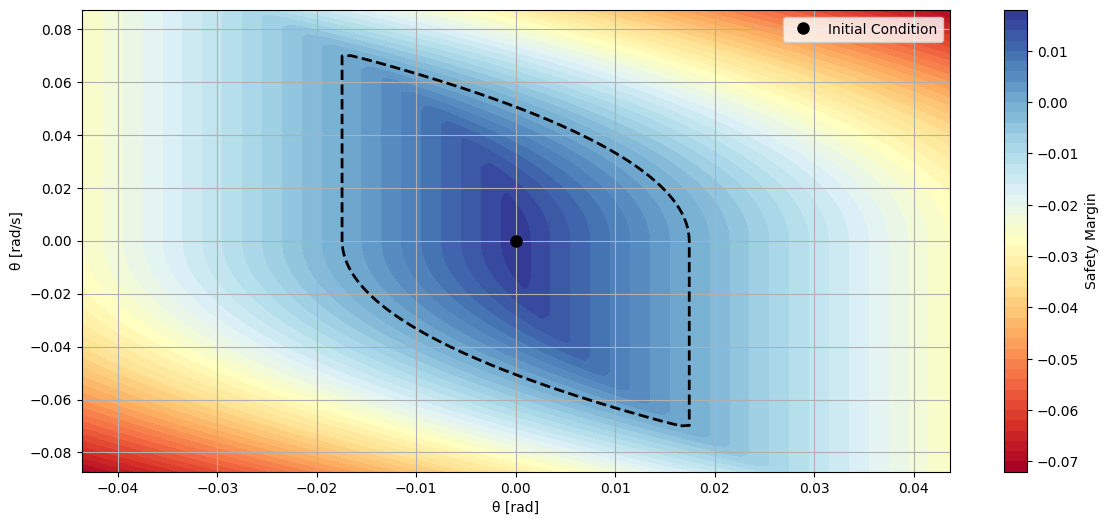

In [88]:
# Choose a slice index or ell value
ell_index = grid.shape[2] // 2  # middle of ell range
ell_val = grid.coordinate_vectors[2][ell_index]

# Extract 2D slice of value function at fixed ℓ
V_slice = target_values[:, :, ell_index]

# Plot
plt.figure(figsize=(14, 6))
plt.contourf(
    grid.coordinate_vectors[0],
    grid.coordinate_vectors[1],
    V_slice.T,  # transpose for correct orientation
    levels=50,
    cmap='RdYlBu'
)
plt.colorbar(label='Safety Margin')

# Plot zero level set (boundary of reachable set)
plt.contour(
    grid.coordinate_vectors[0],
    grid.coordinate_vectors[1],
    V_slice.T,
    levels=[0],
    colors='black',
    linewidths=2,
    linestyles='dashed'
)

# Initial condition (θ0, θ̇0)
plt.plot(0, 0, 'ko', markersize=8, label="Initial Condition")

# Labels
plt.xlabel("θ [rad]")
plt.ylabel("θ̇ [rad/s]")
# plt.title(f"CBF Reachable Set Slice at ℓ = {ell_val:.2f} m")
plt.grid(True)
plt.legend()
plt.show()


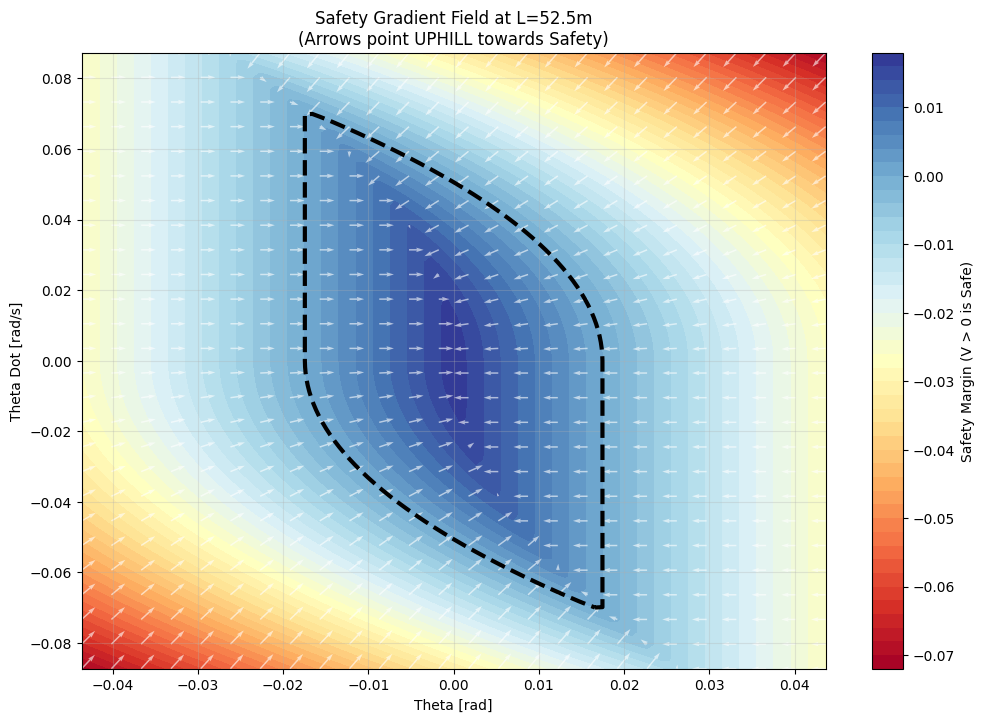

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup Data
ell_index = grid.shape[2] // 2
ell_val = grid.coordinate_vectors[2][ell_index]
V_slice = target_values[:, :, ell_index]

# Create Meshgrid for plotting
theta_vec = grid.coordinate_vectors[0]
thetadot_vec = grid.coordinate_vectors[1]
X, Y = np.meshgrid(theta_vec, thetadot_vec, indexing='ij')

# 2. Compute Gradients numerically
# We use np.gradient to get (dV/dtheta, dV/dthetadot)
d_theta = theta_vec[1] - theta_vec[0]
d_thetadot = thetadot_vec[1] - thetadot_vec[0]

grad_theta, grad_thetadot = np.gradient(V_slice, d_theta, d_thetadot)

# 3. Plot
fig, ax = plt.subplots(figsize=(12, 8))

# A. Contour (Safety Margin)
# Note: X and Y are used directly, no need to transpose V_slice if using 'ij' indexing meshgrid properly
# But standard plt.contourf expects (Y, X) or transposed Z if strictly using vectors.
# Let's stick to your previous working orientation:
cntr = ax.contourf(theta_vec, thetadot_vec, V_slice.T, levels=50, cmap='RdYlBu')
fig.colorbar(cntr, label='Safety Margin (V > 0 is Safe)')

# B. Zero Boundary
ax.contour(theta_vec, thetadot_vec, V_slice.T, levels=[0], colors='black', linewidths=3, linestyles='--')

# C. Quiver (Gradient Arrows)
# We decimate (skip) points so the plot isn't just a black blob of arrows
skip = 4 
# V_slice.T means we must also transpose the gradients to match the plot orientation
ax.quiver(
    X[::skip, ::skip].T, 
    Y[::skip, ::skip].T, 
    grad_theta[::skip, ::skip].T, 
    grad_thetadot[::skip, ::skip].T,
    color='white', 
    alpha=0.6,
    scale=None, # Auto-scale arrows
    width=0.002
)

ax.set_xlabel("Theta [rad]")
ax.set_ylabel("Theta Dot [rad/s]")
ax.set_title(f"Safety Gradient Field at L={ell_val:.1f}m\n(Arrows point UPHILL towards Safety)")
ax.grid(True, alpha=0.3)
plt.show()

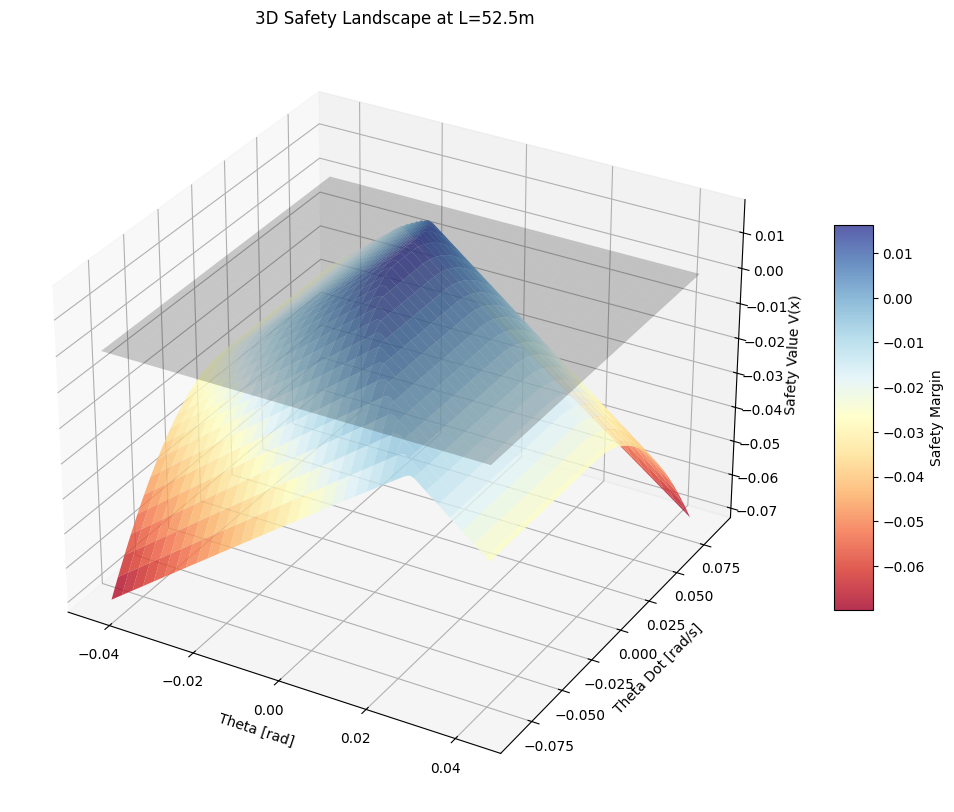

In [90]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Subsample for smoother/faster 3D plotting
stride = 1

# Plot Surface
surf = ax.plot_surface(
    X[::stride, ::stride], 
    Y[::stride, ::stride], 
    V_slice[::stride, ::stride], 
    cmap='RdYlBu', 
    edgecolor='none', 
    alpha=0.8
)

# Plot Zero-Level Plane (The Water Line)
# This helps visually separate Safe (Above) vs Unsafe (Below)
xx, yy = np.meshgrid(theta_vec, thetadot_vec)
zz = np.zeros_like(xx)
ax.plot_surface(xx, yy, zz, color='black', alpha=0.2)

# Labels
ax.set_xlabel('Theta [rad]')
ax.set_ylabel('Theta Dot [rad/s]')
ax.set_zlabel('Safety Value V(x)')
ax.set_title(f"3D Safety Landscape at L={ell_val:.1f}m")

# Add colorbar
fig.colorbar(surf, shrink=0.5, aspect=10, label='Safety Margin')

# Adjust view angle for best perspective
ax.view_init(elev=30, azim=-60)

plt.show()

Generating GIF with 21 frames...
Saved to safety_set_evolution.gif


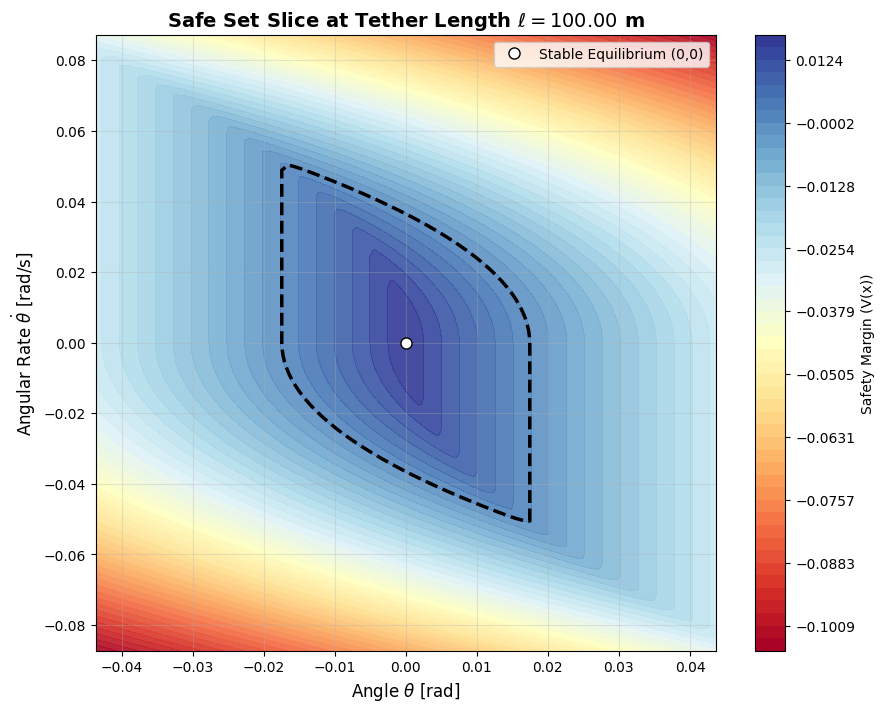

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# --- CONFIGURATION ---
filename = "safety_set_evolution.gif"
fps = 5 # Frames per second

# 1. Setup Data & Limits
# We calculate global limits so the colorbar doesn't "jump" between frames
v_min, v_max = np.min(target_values), np.max(target_values)
# Create fixed levels for consistent contouring
levels = np.linspace(v_min, v_max, 50)

# 2. Initialize Figure
fig, ax = plt.subplots(figsize=(10, 8))

# Pre-add the colorbar based on a dummy plot (so it stays static)
# We plot one invisible contour just to grab the mappable object
dummy = ax.contourf(
    grid.coordinate_vectors[0], 
    grid.coordinate_vectors[1], 
    target_values[:, :, 0].T, 
    levels=levels, 
    cmap='RdYlBu'
)
cbar = fig.colorbar(dummy, ax=ax, label='Safety Margin (V(x))')

def update(frame_idx):
    ax.clear() # Clear previous frame
    
    # A. Get current Ell value and Slice
    ell_val = grid.coordinate_vectors[2][frame_idx]
    V_slice = target_values[:, :, frame_idx]
    
    # B. Plot Value Function (Safety Margin)
    # Note: We use the FIXED levels and v_min/v_max
    ax.contourf(
        grid.coordinate_vectors[0],
        grid.coordinate_vectors[1],
        V_slice.T, # Transpose for (Theta, Theta_dot) orientation
        levels=levels,
        cmap='RdYlBu',
        vmin=v_min,
        vmax=v_max,
        alpha=0.9
    )
    
    # C. Plot Zero Level Set (The Safe Boundary)
    # We only plot this if the zero-level exists in this slice
    if np.min(V_slice) < 0 < np.max(V_slice):
        CS = ax.contour(
            grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            V_slice.T,
            levels=[0],
            colors='black',
            linewidths=2.5,
            linestyles='dashed'
        )
        # Optional: Label the contour
        # ax.clabel(CS, inline=True, fmt='Boundary', fontsize=10)

    # D. Fixed Markers and Labels
    # Initial Condition marker
    ax.plot(0, 0, 'ko', markersize=8, markerfacecolor='white', label="Stable Equilibrium (0,0)")
    
    ax.set_xlabel(r"Angle $\theta$ [rad]", fontsize=12)
    ax.set_ylabel(r"Angular Rate $\dot{\theta}$ [rad/s]", fontsize=12)
    ax.set_title(f"Safe Set Slice at Tether Length $\ell = {ell_val:.2f}$ m", fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Keep axis fixed to grid limits so the view doesn't wobble
    ax.set_xlim(grid.coordinate_vectors[0].min(), grid.coordinate_vectors[0].max())
    ax.set_ylim(grid.coordinate_vectors[1].min(), grid.coordinate_vectors[1].max())

# 3. Create Animation
# Iterates through the 'Ell' dimension (index 2 of the grid)
n_frames = target_values.shape[2]
ani = FuncAnimation(fig, update, frames=n_frames, repeat=True)

# 4. Save
print(f"Generating GIF with {n_frames} frames...")
ani.save(filename, writer=PillowWriter(fps=fps))
print(f"Saved to {filename}")
plt.show()

1. System DynamicsWe model the reel rate $\dot{\ell}$ as a fixed mission parameter (drift), making the system Control-Affine with respect to the single input, Thrust ($T$). The wind $d = V_{wind}$ introduces a nonlinear disturbance via aerodynamic drag.$$\dot{x} = f(x) + g(x) T + \delta(x, d)$$$x = [\theta, \dot{\theta}, \ell]^\top$: State vector.$f(x)$: Nominal drift including Gravity, Coriolis forces (from fixed $\dot{\ell}$), and kinematic evolution.$g(x) = [0, \frac{1}{m\ell}, 0]^\top$: Control authority of Thrust.$\delta(x, d)$: Acceleration due to aerodynamic drag, which depends quadratically on relative velocity $(v - d)^2$.2. Control Barrier Function (CBF)We define the Safe Set $\mathcal{C}$ using the value function $V_{HJ}(x)$ computed via Hamilton-Jacobi Reachability Analysis:$$h(x) = V_{HJ}(x) \quad \implies \quad \mathcal{C} = \{ x \mid h(x) \geq 0 \}$$The gradients $\nabla h(x)$ are obtained via interpolation of the grid solution.3. Robust Safety ConditionTo guarantee safety under the worst-case wind, the control $T$ must satisfy the inequality for the disturbance $d$ that minimizes the barrier derivative $\dot{h}$:$$\underbrace{L_f h(x)}_{\text{Drift}} + \underbrace{L_g h(x)}_{\text{Control}} T + \underbrace{\min_{d \in \mathcal{D}} \left[ \nabla h(x)^\top \delta(x, d) \right]}_{\text{Worst-Case Wind Impact}} \geq -\alpha(h(x))$$We define the Robustness Buffer as the magnitude of the worst-case wind impact:$$\beta(x) = \left| \min_{d \in \mathcal{D}} \left[ \nabla h(x)^\top \delta(x, d) \right] \right|$$(Note: If the wind opposes safety, this term is negative. We move it to the RHS as a positive required margin).4. The Quadratic Program (QP)We solve for the optimal control $T^*$ that tracks a nominal PID command $T_{nom}$ while satisfying the robust safety constraint.$$\begin{aligned}
T^* = \;& \underset{T}{\text{argmin}} \; \frac{1}{2} (T - T_{nom})^2 + \frac{1}{2} w_{slack} \epsilon^2 \\
\text{s.t.} \;& \\
& \text{(1) Safety Constraint:} \\
& \quad L_g h(x) \cdot T \geq -\alpha(h(x)) - L_f h(x) + \beta(x) - \epsilon \\
\\
& \text{(2) Actuation Limits:} \\
& \quad T_{min} \leq T \leq T_{max} \\
\\
& \text{(3) Slack Positivity:} \\
& \quad \epsilon \geq 0
\end{aligned}$$Implementation Note:Since $\delta(x,d)$ is nonlinear, computing $\beta(x)$ analytically is difficult. In practice, we evaluate the drag acceleration at the Maximum Wind Speed in the direction opposing the safety gradient $\nabla h(x)$.

In [92]:
import numpy as np
from jax.scipy.interpolate import RegularGridInterpolator
import cvxpy as cp

# --- 1. Compute Gradients on the Grid ---
print("Computing Gradients of V(x)...")

# Get Grid Vectors
coords = grid.coordinate_vectors 

# np.gradient computes central differences
# Returns tuple: (dV/d_theta, dV/d_theta_dot, dV/d_ell)
grad_V_tuple = np.gradient(target_values, coords[0], coords[1], coords[2], edge_order=2)

# Stack into (N1, N2, N3, 3)
grad_V_grid = np.stack(grad_V_tuple, axis=-1)

print(f"Value Grid Shape: {target_values.shape}")
print(f"Grad Grid Shape:  {grad_V_grid.shape}")

Computing Gradients of V(x)...
Value Grid Shape: (101, 101, 21)
Grad Grid Shape:  (101, 101, 21, 3)


In [93]:
# --- 2. Setup Interpolators ---

# Interpolator for h(x) = V(x)
interp_h = RegularGridInterpolator(
    points=(coords[0], coords[1], coords[2]),
    values=target_values,  # Positive = Safe
    method='linear',
    bounds_error=False,
    fill_value=-1.0 # Unsafe if out of bounds
)

# Interpolator for grad_h(x) = grad_V(x)
interp_grad_h = RegularGridInterpolator(
    points=(coords[0], coords[1], coords[2]),
    values=grad_V_grid,
    method='linear',
    bounds_error=False,
    fill_value=0.0 
)

def get_h_and_grad_h_fast(x_state):
    """ Fast lookup for h and grad_h """
    point = x_state.reshape(1, -1)
    h_val = interp_h(point)[0]
    grad_h_val = interp_grad_h(point).flatten()
    return h_val, grad_h_val

# Class K Function
def alpha_h(h_val, kappa=0.1):
    # Smoothstep-like alpha function
    return kappa * h_val / np.sqrt(1 + h_val**2)

In [94]:
def solve_robust_cbf_qp(x, T_nom, 
                        l_dot_fixed, # The Parameter (Not a control var)
                        f_fn, B_fn, E_fn, # Symbolic Functions
                        params,
                        h_val, grad_h, 
                        T_min, T_max, 
                        wind_max,
                        verbose=False):
    
    # Unpack
    theta, theta_dot, l = x
    m, g, k = params['m'], params['g'], params['k']
    
    # --- A. Evaluate Dynamics ---
    # 1. Drift Vector f(x)
    # Includes Gravity + Coriolis(l_dot_fixed) + Drag(l_dot_fixed, wind=0)
    # We pass T=0, V_wind=0
    f_val = np.array(f_fn(theta, theta_dot, l, 0.0, l_dot_fixed, m, g, k, 0.0)).flatten()
    
    # 2. Control Vector g(x) (Thrust Authority)
    # We evaluate B matrix. Since we fixed l_dot, this is shape (3, 1)
    B_val = np.array(B_fn(theta, theta_dot, l, 0.0, l_dot_fixed, m, g, k, 0.0))
    g_vec = B_val.flatten() # Shape (3,)
    
    # 3. Disturbance Sensitivity E(x) (Wind Authority)
    # We assume HEADWIND logic to get the max sensitivity slope
    # If moving right (theta_dot > 0), wind from right is worst (-wind_max)
    worst_wind_dir = -np.sign(theta_dot) if abs(theta_dot) > 1e-4 else 1.0
    d_worst = worst_wind_dir * wind_max
    
    E_val = np.array(E_fn(theta, theta_dot, l, 0.0, l_dot_fixed, m, g, k, d_worst)).flatten()

    # --- B. Compute Lie Derivatives ---
    Lf_h = np.dot(grad_h, f_val).item()   # Scalar
    Lg_h = np.dot(grad_h, g_vec).item()   # Scalar (Effect of Thrust)
    LE_h = np.dot(grad_h, E_val).item()   # Scalar (Effect of Wind Sensitivity)
    
    # 2. ROBUST WIND (Calculate BOTH directions and take the worst)
    # This removes the "flickering" near zero velocity
    E_pos = np.array(E_fn(theta, theta_dot, l, 0.0, l_dot_fixed, m, g, k,  wind_max)).flatten()
    E_neg = np.array(E_fn(theta, theta_dot, l, 0.0, l_dot_fixed, m, g, k, -wind_max)).flatten()
    
    # The buffer is the worst-case impact on h
    buf_pos = np.dot(grad_h, E_pos)
    buf_neg = np.dot(grad_h, E_neg)
    
    # In affine CBF, wind acts as L_d * d. We move it to RHS.
    # We want the term that makes the inequality HARDEST to satisfy.
    # Condition: Lg*u >= ... + Buffer
    # If wind helps (positive dot product), Buffer is negative (relaxed).
    # If wind hurts (negative dot product), Buffer is positive (tighter).
    # We take the max hurt.
    robust_buffer = max(-buf_pos, -buf_neg, 0.0)
    
    # --- D. Formulate QP ---
    # Variable: Thrust (Scalar)
    T = cp.Variable(1)
    slack = cp.Variable(1, nonneg=True)
    
    # Objective: Track Nominal Thrust
    objective = cp.Minimize(
        cp.sum_squares(T - T_nom) + 
        1e10 * slack
    )
    
    # Constraint: Lf + Lg*T + L_wind >= -alpha
    # Worst case wind is negative impact: -Buffer
    # Rearranged: Lg*T >= -alpha - Lf + Buffer - slack
    
    alpha_val = alpha_h(h_val)
    required_safety = -alpha_val - Lf_h + robust_buffer
    constraints = [
        T >= T_min, 
        T <= T_max,
        Lg_h * T >= -alpha_val - Lf_h + robust_buffer - slack
    ]
    
    prob = cp.Problem(objective, constraints)
    
    # Debug Prints
    if verbose:
        T_opt = T.value[0] if T.value is not None else T_nom
        slack_val = slack.value[0] if slack.value is not None else 0.0
        
        # Calculate Max Possible Control Effect
        # If Lg_h is positive, T_max helps. If negative, T_min helps.
        if abs(Lg_h) < 1e-8:
            max_control_effect = 0.0
        elif Lg_h > 0:
            max_control_effect = Lg_h * T_max
        else:
            max_control_effect = Lg_h * T_min
            
        print(f"\n--- QP DIAGNOSTIC (θ={np.rad2deg(theta):.2f}°, l={l:.1f}m) ---")
        print(f"  Barrier h(x) : {h_val:.5f} {'[UNSAFE]' if h_val < 0 else '[SAFE]'}")
        print(f"  Grad_h(x)    : {grad_h}")
        print(f"  Lg_h (Auth)  : {Lg_h:.6f}  <-- Is this zero?")
        print(f"  Buffer       : {robust_buffer:.6f}  <-- Is this zero?")
        print(f"  Required RHS : {required_safety:.5f}")
        print(f"  Max Possible : {max_control_effect:.5f}")
        
        if slack_val > 1e-4:
            print(f"  [FAILURE] QP Gave Up! Slack used: {slack_val:.5f}")
            if abs(Lg_h) < 1e-6:
                print("  -> REASON: Zero Control Authority (Gradient is flat wrt Velocity)")
            elif max_control_effect < required_safety:
                print("  -> REASON: Actuation Saturation (Motor too weak)")

    try:
        prob.solve(warm_start=True, verbose=False)
    except:
        return np.array([T_nom])

    if T.value is None:
        return np.array([T_nom])
        
    return np.array(T.value)

In [95]:
def run_simulation_robust(wind_profile, x_init, gains, dt, N):
    
    x_hist = np.zeros((N + 1, 3))
    u_hist = np.zeros((N, 2)) # Store T and l_dot for plotting
    h_hist = np.zeros(N)
    
    x_hist[0] = x_init
    curr_x = x_init
    integral_err = 0.0
    
    # Fixed Mission Parameter
    L_DOT_FIXED = 1.5 
    
    print(f"Starting Robust CBF Simulation (l_dot={L_DOT_FIXED})...")
    
    for i in range(N):
        curr_wind = wind_profile[i]
        
        # 1. Nominal PID (Thrust Only)
        thrust_nom, integral_err = pid_control_law(
            eqm_theta, curr_x, integral_err, dt,
            gains['Kp'], gains['Ki'], gains['Kd'],
            curr_wind, base_params['k']
        )
        # Inside run_simulation_robust loop, before step 2:
        if curr_x[2] < ell_min or curr_x[2] > ell_max:
            print(f"[CRITICAL] State x={curr_x} is OUTSIDE GRID BOUNDS l=[{ell_min}, {ell_max}]")
        # 2. Get Barrier Info
        h_val, grad_h_val = get_h_and_grad_h_fast(curr_x)
        h_hist[i] = h_val
        
        # 3. Solve Robust QP (Optimizes Thrust Only)
        u_thrust_safe = solve_robust_cbf_qp(
            x=curr_x,
            T_nom=thrust_nom,
            l_dot_fixed=L_DOT_FIXED,
            f_fn=f_fn, B_fn=B_fn, E_fn=E_fn,
            params=base_params,
            h_val=h_val, 
            grad_h=grad_h_val,
            T_min=-u_max_val, T_max=u_max_val,
            wind_max=v_gust,
            verbose=(i % 10 == 0)
        )
        
        # 4. Formulate Full Control Vector for Dynamics
        # u = [Thrust, l_dot]
        u_applied = np.array([u_thrust_safe[0], L_DOT_FIXED])
        
        # 5. Step Dynamics (Nonlinear Truth)
        m, g, k = base_params['m'], base_params['g'], base_params['k']
        
        # Arguments: (theta, theta_dot, l, T, l_dot, m, g, k, V_wind)
        # Note: We pass the APPLIED controls here
        args_nl = (curr_x[0], curr_x[1], curr_x[2], 
                   u_applied[0], u_applied[1], 
                   m, g, k, curr_wind)
        
        x_dot = np.array(f_fn(*args_nl)).flatten()
        curr_x = curr_x + x_dot * dt
        
        x_hist[i+1] = curr_x
        u_hist[i] = u_applied

    return x_hist, u_hist, h_hist

Running Robust CBF Simulation...
Starting Robust CBF Simulation (l_dot=1.5)...

--- QP DIAGNOSTIC (θ=0.00°, l=5.0m) ---
  Barrier h(x) : 0.01745 [SAFE]
  Grad_h(x)    : [-1.81520221e-07 -3.49342644e-09 -1.17812625e-07]
  Lg_h (Auth)  : -0.000000  <-- Is this zero?
  Buffer       : 0.000000  <-- Is this zero?
  Required RHS : -0.00174
  Max Possible : 0.00000

--- QP DIAGNOSTIC (θ=-0.10°, l=6.5m) ---
  Barrier h(x) : 0.01491 [SAFE]
  Grad_h(x)    : [ 9.9793869e-01  5.2273296e-02 -1.2605179e-04]
  Lg_h (Auth)  : 0.001608  <-- Is this zero?
  Buffer       : 0.000000  <-- Is this zero?
  Required RHS : 0.02877
  Max Possible : 0.03217


/var/folders/z9/89vjptjj08sg519b08sjknd40000gn/T/ipykernel_14722/2239250635.py:110: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  prob.solve(warm_start=True, verbose=False)



--- QP DIAGNOSTIC (θ=0.27°, l=8.0m) ---
  Barrier h(x) : 0.01273 [SAFE]
  Grad_h(x)    : [-9.9999917e-01  1.5272548e-07  2.5424458e-11]
  Lg_h (Auth)  : 0.000000  <-- Is this zero?
  Buffer       : 0.000000  <-- Is this zero?
  Required RHS : -0.01984
  Max Possible : 0.00000

--- QP DIAGNOSTIC (θ=0.00°, l=9.5m) ---
  Barrier h(x) : 0.01736 [SAFE]
  Grad_h(x)    : [ 8.578151e-03  1.802991e-02 -7.276923e-06]
  Lg_h (Auth)  : 0.000380  <-- Is this zero?
  Buffer       : 0.000000  <-- Is this zero?
  Required RHS : -0.00170
  Max Possible : 0.00759

--- QP DIAGNOSTIC (θ=-0.05°, l=11.0m) ---
  Barrier h(x) : 0.01653 [SAFE]
  Grad_h(x)    : [ 9.9880439e-01  1.2745096e-03 -6.1164509e-09]
  Lg_h (Auth)  : 0.000023  <-- Is this zero?
  Buffer       : 0.000000  <-- Is this zero?
  Required RHS : -0.00201
  Max Possible : 0.00046

--- QP DIAGNOSTIC (θ=0.00°, l=12.5m) ---
  Barrier h(x) : 0.01711 [SAFE]
  Grad_h(x)    : [-2.1201251e-01 -4.4258129e-02 -2.4200874e-05]
  Lg_h (Auth)  : -0.000708  <

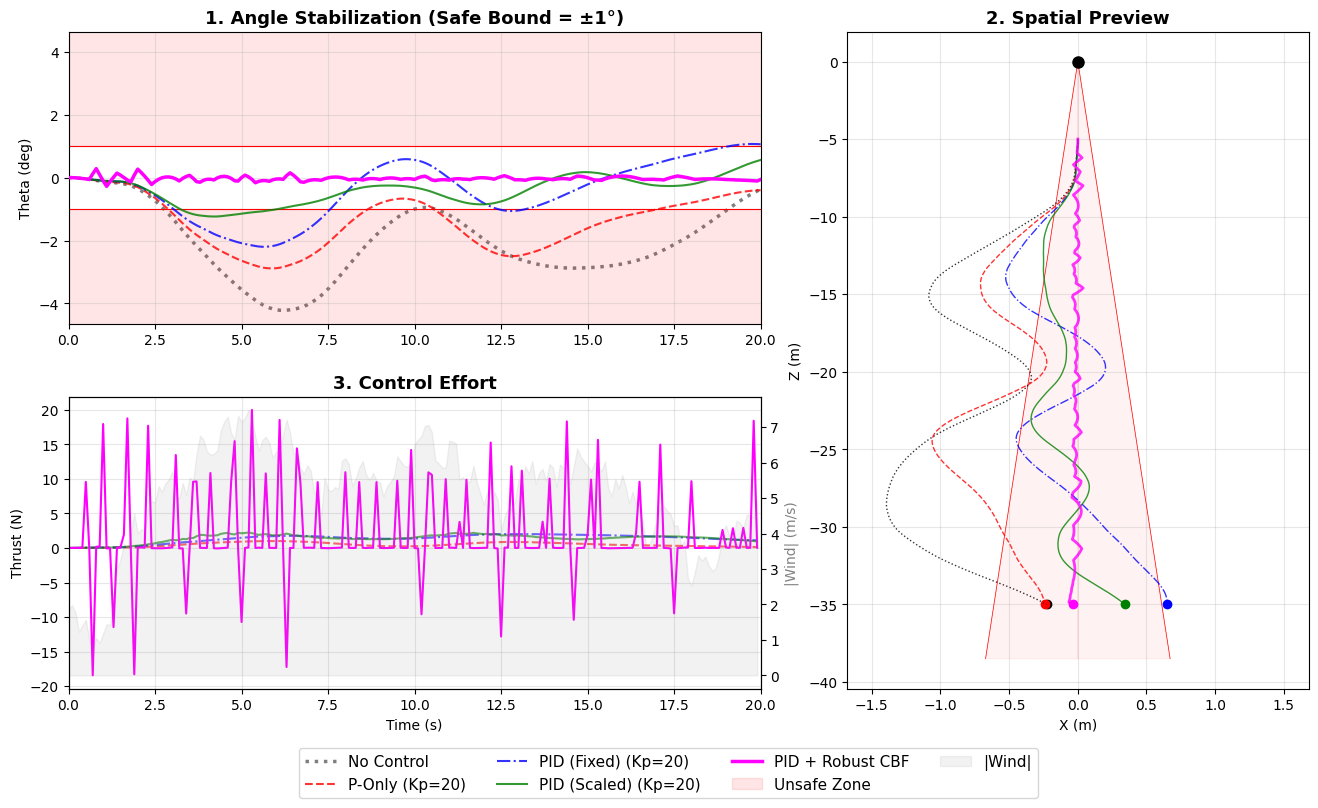

In [96]:
# --- 3. RUN ROBUST CBF CASE ---
# We use the EXISTING 'wind_data' and 'results' from the previous cell.

# 1. Run the Robust Solver
print("Running Robust CBF Simulation...")
cbf_gains = {'Kp': Kp, 'Ki': Ki, 'Kd': Kd}

# Note: run_simulation_robust needs to be defined from previous steps
x_cbf, u_cbf, h_cbf = run_simulation_robust(wind_data, x0, cbf_gains, dt, N)

# 2. Add to existing results dictionary
results['PID + CBF'] = {
    'x': x_cbf,
    'u': u_cbf[:, 0],    # Extract Thrust column only
    'label': 'PID + Robust CBF',
    'color': 'magenta',  # High visibility
    'style': '-'         # Solid line implies authority
}

# 3. Re-Plot Everything (Standard PID + New CBF)
plot_all_results(results, wind_data, angle_bound_deg, T_sim, dt)